# Microsoft & NVIDIA 动手工作坊：

### 在 NVIDIA Jetson上开启 Microsoft OpenAI Service, 体验AIGC的实现流程
![](images/azure_aigc.png)

## 实验:
1. 利用TensorRT优化Resnet50模型, 识别输入图像内容
2. 利用Azure OpenAI接口, 将识别内容生成一段故事
3. 利用NGC SDXL平台, 根据文字内容生成图片

### 1.利用TensorRT优化Resnet50模型
将resnet50.onnx转换成TensorRT推理引擎

生成的推理引擎将保存在`plan`文件夹

In [1]:
import sys
import tensorrt as trt

def main():
    print("Convert Onnx model to TensorRT Plan")

    onnx_path = "./onnx/resnet50.onnx"
    plan_path = "./plan/resnet50.plan"

    logger = trt.Logger()
    builder = trt.Builder(logger)
    network = builder.create_network(1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH))
    config = builder.create_builder_config()
    config.max_workspace_size = 256 * 1024 * 1024
    config.set_flag(trt.BuilderFlag.DISABLE_TIMING_CACHE)

    parser = trt.OnnxParser(network, logger)
    ok = parser.parse_from_file(onnx_path)
    if not ok:
        sys.exit("ONNX parse error")

    plan = builder.build_engine(network, config)
    plan = plan.serialize()
    with open(plan_path, "wb") as fp:
        fp.write(plan)

    print("DONE")

main()

Convert Onnx model to TensorRT Plan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Use build_serialized_network instead.


DONE


### 2.查看上传的图片

可以自己上传任意两张图片到`data`文件夹, 将图片分别命名为`img0.jpg`, `img1.jpg`。

后面推理引擎将会识别这两张图片的内容

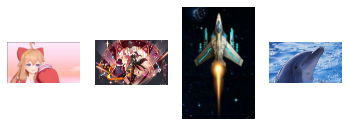

In [2]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import json 

fig, axes = plt.subplots(nrows=2, ncols=2)

for i in range(4):
    img_path = './data/img%d.jpg'%i
    img = Image.open(img_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(img)      
    # Display the image in the subplot
    plt.subplot(1,4,i+1)
    plt.imshow(img)
    plt.axis('off')

# loading labels    
with open("./data/imagenet_class_index.json") as json_file: 
    d = json.load(json_file)

### 3.利用TensorRT识别上传的图片

利用TensorRT识别上传的两张图片, 将图片内容提取出关键字。

**注意**: 第一次运行的时候由于要从硬盘加载模型可能稍慢, 再次执行将有明显速度提升

In [3]:
# 定义前处理和后处理方法, 加载引擎并定义推理过程
import sys
import numpy as np
import pycuda.autoinit
import pycuda.driver as cuda
import tensorrt as trt
from PIL import Image
from torchvision import transforms

def softmax(x):
    y = np.exp(x)
    sum = np.sum(y)
    y /= sum
    return y

def topk(x, k):
    idx = np.argsort(x)
    idx = idx[::-1][:k]
    return (idx, x[idx])

def rn50_preprocess():
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return preprocess


def inference(input_path, key_words):

    onnx_path = "./onnx/resnet50.onnx"
    plan_path = "./plan/resnet50.plan"

    # read the plan
    with open(plan_path, "rb") as fp:
        plan = fp.read()



    # read the categories
    with open("./data/imagenet_classes.txt", "r") as f:
        categories = [s.strip() for s in f.readlines()]

    # initialize the TensorRT objects
    logger = trt.Logger()
    runtime = trt.Runtime(logger)
    engine = runtime.deserialize_cuda_engine(plan)
    context = engine.create_execution_context()

    # copy input to device, run inference, copy output to host
    for img in input_path:
        # read the pre-processed image
        input = Image.open(img)
        if input.mode != 'RGB':
            input = input.convert('RGB')
        preprocess = rn50_preprocess()
        input = preprocess(input).cpu().numpy()
        
        # create device buffers and TensorRT bindings
        output = np.zeros((1000), dtype=np.float32)
        d_input = cuda.mem_alloc(input.nbytes)
        d_output = cuda.mem_alloc(output.nbytes)
        bindings = [int(d_input), int(d_output)]
        
        cuda.memcpy_htod(d_input, input)
        context.execute_v2(bindings=bindings)
        cuda.memcpy_dtoh(output, d_output)

    # apply softmax and get Top-5 results
        output = softmax(output)
        top5p, top5v = topk(output, 5)

        key_words.append(categories[top5p[0]])
        
    return key_words

开始推理任务, 将提取到的关键字保存在**key_words**列表中

In [4]:
input_path = ["./data/img0.jpg","./data/img1.jpg","./data/img2.jpg","./data/img3.jpg"]
key_words = []
inference(input_path, key_words)
    
print(key_words)

['mask', 'toyshop', 'space shuttle', 'great white shark']


### 4.利用Microsoft OpenAI Service, 将识别内容生成一段故事

将提取的关键字组合成接口要求的格式

In [5]:
import subprocess

#preprocessing key words to Azure api
key_words_to_azure = ""
for key_word in key_words:
    key_words_to_azure += key_word+', '

key_words_to_azure = "\'{\"catalog\":\"%s\"}\'"%key_words_to_azure[:-2]


定义CURL命令, 利用CURL获取Microsoft OpenAI Service输出

In [6]:
# 定义CURL命令
curl_command = 'curl https://nvidiastory.azurewebsites.net/api/story?code=8wqZyNEKZMcCmjsFUcQb-5XA6pJJeWX6-Vu61F9Z9iitAzFuezDPzQ== -X POST -d {}'.format(key_words_to_azure)
print(curl_command)
# 执行cURL命令并获取输出
output = subprocess.check_output(curl_command, shell=True)

# 将输出转换为字符串
output = output.decode('utf-8')

# 打印输出
print('\n\nOutput:\n\n'+output)

curl https://nvidiastory.azurewebsites.net/api/story?code=8wqZyNEKZMcCmjsFUcQb-5XA6pJJeWX6-Vu61F9Z9iitAzFuezDPzQ== -X POST -d '{"catalog":"mask, toyshop, space shuttle, great white shark"}'


Output:

Once upon a time, a witty mask-wearing toyshop owner embarked on a magical adventure to space in a space shuttle, only to befriend a hilarious great white shark who mistakenly thought he was a toy.


### 5.利用NGC平台, 根据输出的文字内容生成图片

访问: [NGC SDXL](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/playground/models/sdxl)网址, 将上面输出的文字内容复制, 粘贴到prompt框中(下图红色框的位置), 点击生成按钮(下图蓝色框的位置), 用NGC SDXL平台生成图像

**注意**: NGC SDXL平台使用前需要注册

![](images/ngc_aigc.png)